### Deleterious variants in know cancer genes.
Only curated rare missense variants in knonw cancer genes, plus truncation variants in TSGs.

In [18]:
setwd('~/Documents/Project/germVar')
library(germVar2)
library(gridExtra)
patho_muts <- rbind(subset(nsSNP_muts, uid %in% subset(nsSNP_vars, rare&(MDG|CPG)& dele)$uid), subset(LoF_muts, Class%in% c("H-TSG", "M-TSG")))
# dimension
dim(patho_muts)
# number of unique variants
length(unique(patho_muts$uid))
# breakdown variants
table(subset(patho_muts, !duplicated(uid))$EFF)
# number of unique patients
length(unique(patho_muts$Patient))

Loading required package: grid


[1] 1149   17

[1] 723


            frameshift_variant  frameshift_variant+start_lost 
                           272                              1 
frameshift_variant+stop_gained               missense_variant 
                             5                            125 
       splice_acceptor_variant           splice_donor_variant 
                            48                             52 
                    start_lost                    stop_gained 
                            13                            206 
 stop_gained+inframe_insertion 
                             1 

[1] 1068

### Plot the age at diagnosis of various groups of variant carriers. 
Some patients have multiple variants. When grouping them, BRCA1/2 > OG > H-TSG > M-TSG

Warning message:
: Removed 1 rows containing missing values (geom_point).Warning message:
: Removed 1 rows containing missing values (geom_point).Warning message:
: Removed 4 rows containing missing values (geom_point).Warning message:
: Removed 43 rows containing missing values (geom_point).Warning message:
: Removed 1 rows containing missing values (geom_point).Warning message:
: Removed 1 rows containing missing values (geom_point).Warning message:
: Removed 4 rows containing missing values (geom_point).Warning message:
: Removed 43 rows containing missing values (geom_point).

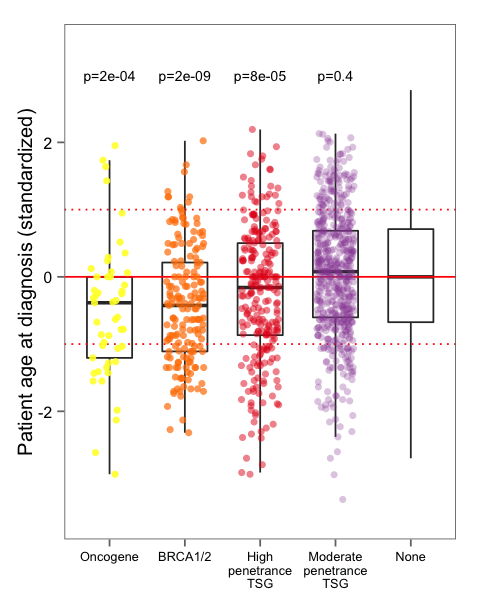

In [16]:
options(repr.plot.height = 5, repr.plot.width = 4.)
all_patients$carrier <- "None"
all_patients$carrier[with(all_patients, Patient %in% subset(patho_muts, Gene %in% c("BRCA1", "BRCA2"))$Patient)] <- "BRCA1/2"
all_patients$carrier[with(all_patients, carrier=="None" & Patient %in% subset(patho_muts, Class=="OG")$Patient)] <- "OG"
all_patients$carrier[with(all_patients, carrier=="None" & Patient %in% subset(patho_muts, Class=="H-TSG")$Patient)] <- "H-TSG"
all_patients$carrier[with(all_patients, carrier=="None" & Patient %in% subset(patho_muts, Class=="M-TSG")$Patient)] <- "M-TSG"

all_patients$carrier <- factor(all_patients$carrier, levels=c("OG", "BRCA1/2", "H-TSG", "M-TSG", "None"))

age_test <- function(df) {
  test <- wilcox.test(df$agez, subset(all_patients, carrier=="None")$agez)
  return(data.frame(pval = test$p.value, pval_label = paste("p=", signif(test$p.value, 1), sep="")))
}
carrier_age <- group_by(droplevels(subset(all_patients, carrier!="None")), carrier) %>% do(age_test(.))

p <- ggplot(subset(all_patients, !is.na(agez)), aes(carrier, agez)) +geom_boxplot(outlier.size=NA, width=0.8)
p <- p + geom_hline(yintercept=0, color="red") 
p <- p + geom_hline(yintercept=1, linetype=3, color="red") 
p <- p + geom_hline(yintercept=-1, linetype=3, color="red" )
p <- p + theme_few() +  geom_jitter(data = subset(all_patients, !is.na(agez) & carrier!="None"), aes(color=carrier, alpha=carrier), position = position_jitter(width = .25, height=0))
p <- p + scale_color_manual(values=c("#ffff33", "#ff7f00","#e41a1c", "#984ea3"), guide="none")
p <- p + scale_alpha_discrete(range=c(0.9, 0.3), guide="none")
p <- p + ylab("Patient age at diagnosis (standardized)") + labs(x=NULL) 
p <- p + theme(axis.text.x =element_text(size=rel(.8), angle=0))
p <- p + scale_x_discrete(labels = c( "OG"="Oncogene",  "BRCA1/2"="BRCA1/2",  "H-TSG"="High\npenetrance\nTSG", "M-TSG"="Moderate\npenetrance\nTSG", "None"="None"))
p <- p + geom_text(aes(x=carrier, y=3., label=pval_label), data= carrier_age, color="black", size=3)
p
ggsave(file="Figures/Patho_muts_Class_patient_age.pdf", width=4, height=4)


### Tally the variant carriers in each cancer type

[1] 0.108

[1] 0.0376

Warning message:
: Stacking not well defined when ymin != 0

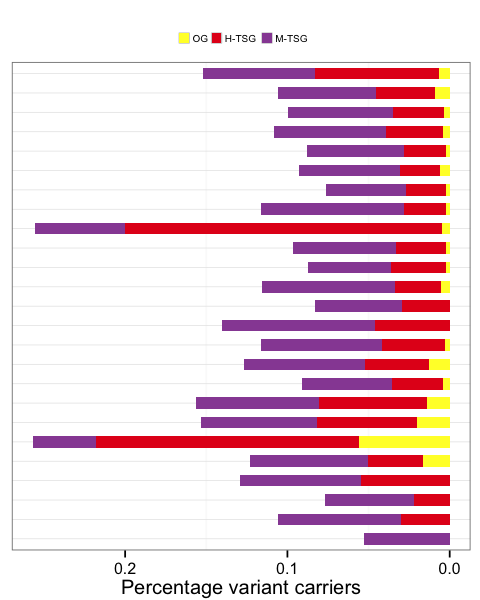

In [19]:
all_patients$Class <- all_patients$carrier
all_patients$Class[all_patients$Class=="BRCA1/2"] <- "H-TSG"
disease_tally <- subset(all_patients, carrier!="None") %>% droplevels(.) %>% 
                 group_by(., disease2, Class, study_size) %>% 
                 dplyr::summarise(., N_Pat_Class = length(unique(Patient)), P_Pat_Class = N_Pat_Class/unique(study_size)) 
# calculate median percentage for all carriers
P_Pat <- group_by(disease_tally, disease2) %>% dplyr::summarise(., P_Pat = sum(P_Pat_Class)) %>% as.data.frame() %>% arrange(., P_Pat) 
signif(median(P_Pat$P_Pat), 3)
# calculate median percentage for OG/H-TSG carriers
P_Pat <- group_by(subset(disease_tally, Class!="M-TSG"), disease2) %>% dplyr::summarise(., P_Pat = sum(P_Pat_Class)) %>% as.data.frame() %>% arrange(., P_Pat) 
signif(median(P_Pat$P_Pat), 3)

p2 <- ggplot(disease_tally, aes(reorder(disease2, study_size), P_Pat_Class)) 
p2 <- p2 + theme_bw() + coord_flip() + scale_y_reverse()
p2 <- p2 + geom_bar(stat="identity", aes(fill=Class), width=0.6) 
p2 <- p2 + scale_fill_manual(values=c("#ffff33", "#e41a1c", "#984ea3"))
p2 <- p2 + guides(fill=guide_legend(keywidth = 0.4, keyheight = 0.4, ncol=3, title=NULL))
p2 <- p2 + theme(legend.text=element_text(size=6))
p2 <- p2 + labs(x=NULL)+ ylab("Percentage variant carriers")
p2 <- p2 + theme(axis.text.y= element_blank(), axis.ticks.y=element_blank())
p2 <- p2 + theme( legend.position= "top", axis.title.y = element_text(size=rel(.9)), legend.margin = unit(0, "cm"))
p2 <- p2 + theme( panel.grid.major.x=element_blank(), plot.margin = unit(c(0.3,0.2,0,0), "cm"))
p2